In [1]:
import networkx as nx

In [2]:
from abc import ABC, abstractmethod
import pyzx as zx
import stim

class CircuitBuilder(ABC):
    @abstractmethod
    def add_h(self, qubit): pass
    
    @abstractmethod
    def add_cnot(self, control, target): pass
    
    @abstractmethod
    def init_ancilla(self, qubit): 
        """Inits ancilla and applies H for your specific extraction logic."""
        pass
    
    @abstractmethod
    def post_select(self, qubit): 
        """Applies H and post-selects (or measures) for your logic."""
        pass

    @abstractmethod
    def get_circuit(self): pass

class PyZXBuilder(CircuitBuilder):
    def __init__(self):
        self.circ = zx.Circuit(0)
    def add_h(self, q): self.circ.add_gate("H", q)
    def add_cnot(self, c, t): self.circ.add_gate("CNOT", c, t)
    def init_ancilla(self, q):
        self.circ.add_gate("InitAncilla", q)
        self.add_h(q)
    def post_select(self, q):
        self.add_h(q)
        self.circ.add_gate("PostSelect", q)
    def get_circuit(self): return self.circ

class StimBuilder(CircuitBuilder):
    def __init__(self):
        self.circ = stim.Circuit()
    def add_h(self, q): self.circ.append("H", q)
    def add_cnot(self, c, t): self.circ.append("CNOT", [c, t])
    def init_ancilla(self, q): pass
    def post_select(self, q):
        self.circ.append("MR", q) # Stim treats post-selection usually via measurement/detectors
    def get_circuit(self): return self.circ

In [3]:
def ed(v1, v2):
    return tuple(sorted((v1, v2)))

def extract_circuit(G, path_cover, marks, matching, builder: CircuitBuilder):
    # 1. Setup Markings
    marks_map = {ed(v1, v2): int(v) for (v1, v2), v in (marks.items() if isinstance(marks, dict) else [(e, 1) for e in marks])}
    
    # 2. Setup Indexing
    cover_edges = {ed(u, v) for path in path_cover for u, v in zip(path, path[1:])}
    num_flags = len([e for e in G.edges() if ed(*e) not in cover_edges])
    flag_dict = {}
    next_cat = num_flags + len(path_cover)

    # 3. Initial Setup
    for qidx in range(next_cat):
        builder.init_ancilla(qidx)

    def handle_link(path_qubit, link, decrement=False):
        nonlocal next_cat
        if link not in flag_dict:
            flag_dict[link] = len(flag_dict)
            builder.add_cnot(path_qubit, flag_dict[link])
        else:
            fq = flag_dict[link]
            for _ in range(marks_map.get(link, 0) - (1 if decrement else 0)):
                builder.init_ancilla(next_cat)
                builder.add_cnot(fq, next_cat)
                next_cat += 1
            builder.add_cnot(path_qubit, fq)
            builder.post_select(fq)

    # 4. Main Loop
    for p_id, path in enumerate(path_cover):
        path_q = num_flags + p_id
        builder.add_h(path_q) # Unfuse path start

        # Neighbors of v0
        v0, v1 = path[0], path[1]
        for n in set(G.neighbors(v0)) - {v1}:
            handle_link(path_q, ed(v0, n))
        
        # Path segments and internal nodes
        for i, v_curr in enumerate(path[1:-1], 1):
            v_prev, v_next = path[i-1], path[i+1]
            # Internal non-cover neighbor
            for n in set(G.neighbors(v_curr)) - {v_prev, v_next}:
                handle_link(path_q, ed(v_curr, n))
            # Markings on the path itself
            for _ in range(marks_map.get(ed(v_prev, v_curr), 0)):
                builder.init_ancilla(next_cat)
                builder.add_cnot(path_q, next_cat)
                next_cat += 1

        # End of path logic
        if len(path) > 2:
            v_last, v_pen = path[-1], path[-2]
            ends = list(set(G.neighbors(v_last)) - {v_pen})
            if matching.get(v_last) == ends[0]: ends.reverse()
            for end_v in ends:
                handle_link(path_q, ed(v_last, end_v), decrement=(matching.get(v_last) == end_v))

    return builder.get_circuit()

Visualizing matching...


/Users/richie.yeung/.pyenv/versions/3.11.11/envs/zxlive/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


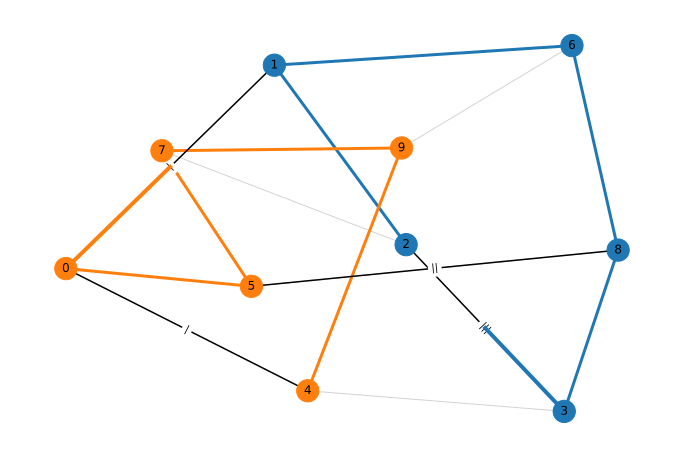

In [4]:
from qubit_lines import draw_qubit_lines_state

G = nx.petersen_graph()
pos = nx.spring_layout(G)

paths= [[2, 1, 6, 8, 3], [4, 9, 7, 5, 0]]
marks = {(0, 1): 1, (0, 4): 1, (8, 5): 2, (3, 2): 3}
match = {3: 2, 0: 1}

draw_qubit_lines_state(G, paths, marks, match)

In [5]:
# To get a PyZX circuit:
zx_circ = extract_circuit(G, paths, marks, match, PyZXBuilder())

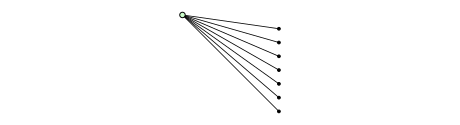

In [6]:
g = zx_circ.to_graph()
zx.full_reduce(g)
zx.draw_matplotlib(g)

In [7]:
# To get a Stim circuit:
stim_circ = extract_circuit(G, paths, marks, match, StimBuilder())

cat_size = sum(marks.values())

n_qubits = stim_circ.num_qubits
cat_size = sum(marks.values())
for i in range(cat_size):
    stim_circ.append('MR', n_qubits - i - 1)

# circ.append('MR', 7)
print(stim_circ.diagram("timeline-text"))

sampler = stim_circ.compile_sampler()
sample = sampler.sample(5)

print('cat size', cat_size)

print('flags\n', sample[:, :-cat_size])
print('cat state\n', sample[:, -cat_size:])

# # # all post selections are 0
# # assert sample[:, :-cat_size].sum() == 0

# # # all 0 or all 1s
# # assert (sample[:, -cat_size:].sum(axis=0) % cat_size == 0).all()

 q0: ---X-----------@-@-X-MR:rec[0]------------------------------------------------------------------------------
        |           | | |
 q1: ---|-X---------|-|-|-------------------------------------X-MR:rec[3]----------------------------------------
        | |         | | |                                     |
 q2: ---|-|-X-------|-|-|-------------------------------------|-------------------------------------X-MR:rec[6]--
        | | |       | | |                                     |                                     |
 q3: ---|-|-|-X-----|-|-|-------------------------X-MR:rec[2]-|-------------------------------------|------------
        | | | |     | | |                         |           |                                     |
 q4: ---|-|-|-|-X---|-|-|-------------------------|-----------|-@---------@-X-MR:rec[4]-------------|------------
        | | | | |   | | |                         |           | |         | |                       |
 q5: ---|-|-|-|-|-X-|-|-|---------